In [67]:
import pandas as pd
import numpy as np
#import tiingo
import requests


#### Remove holdiays from timeseries

In [68]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
cal = calendar()

holidays = cal.holidays(start='2000-01-01',
                        end='2030-12-30')

holiday_df = pd.DataFrame(data=holidays,
                          columns = ['date']).assign(holiday='USFederalHoliday')

In [69]:
### First we will get the 15min time intervals and calculate the 15min Moving averages (10 perido, 20 period, 50 period)
### From the same data we will also calculate the 1d Moving averages (10 period, 20 period, 50 period) and
### Append the indicators to the dataframe 
### Each iteration will run for a single ticker


### The data extracts work in 0GMT => Exchange opens at 14:30 and closes at 21:00
### Convert this to Sofia/New-York time if needed


#### Connect to tiingo

In [70]:
# 15min to # 1h 
headers = {
    'Content-Type': 'application/json'
}
requestResponse = requests.get("https://api.tiingo.com/iex/SPY/prices?startDate=2015-01-02&endDate=2022-12-31&resampleFreq=1hour&columns=open,high,low,close,volume&token=0ed744c7db5ef348139953912e2f3cee79f4608b", headers=headers)
#print(requestResponse.json())

In [71]:
df_stock = pd.DataFrame(requestResponse.json()) 
df_stock

,date,open,high,low,close,volume
0,2017-06-12T17:00:00.000Z,242.485,242.940,242.440,242.495,88095.0
1,2017-06-12T18:00:00.000Z,242.505,243.070,242.485,242.960,128621.0
2,2017-06-12T19:00:00.000Z,242.975,243.390,242.800,243.335,240045.0
3,2017-06-12T20:00:00.000Z,243.325,243.385,243.300,243.335,0.0
4,2017-06-13T14:00:00.000Z,244.055,244.160,243.670,243.680,0.0
...,...,...,...,...,...,...
9995,2022-12-01T17:00:00.000Z,406.825,407.740,405.530,407.310,89664.0
9996,2022-12-01T18:00:00.000Z,407.310,408.030,406.315,407.115,94680.0
9997,2022-12-01T19:00:00.000Z,407.110,408.155,406.410,407.945,100253.0
9998,2022-12-01T20:00:00.000Z,407.945,408.485,407.080,407.350,363974.0


In [72]:
## This gets financial data
#requestResponse = requests.get("https://api.tiingo.com/tiingo/fundamentals/msft/statements?token=0ed744c7db5ef348139953912e2f3cee79f4608b", headers=headers)
#print(requestResponse.json)

In [73]:
requestResponse

<Response [200]>

In [74]:
df_stock = pd.DataFrame(requestResponse.json()) 

In [75]:
df_stock

,date,open,high,low,close,volume
0,2017-06-12T17:00:00.000Z,242.485,242.940,242.440,242.495,88095.0
1,2017-06-12T18:00:00.000Z,242.505,243.070,242.485,242.960,128621.0
2,2017-06-12T19:00:00.000Z,242.975,243.390,242.800,243.335,240045.0
3,2017-06-12T20:00:00.000Z,243.325,243.385,243.300,243.335,0.0
4,2017-06-13T14:00:00.000Z,244.055,244.160,243.670,243.680,0.0
...,...,...,...,...,...,...
9995,2022-12-01T17:00:00.000Z,406.825,407.740,405.530,407.310,89664.0
9996,2022-12-01T18:00:00.000Z,407.310,408.030,406.315,407.115,94680.0
9997,2022-12-01T19:00:00.000Z,407.110,408.155,406.410,407.945,100253.0
9998,2022-12-01T20:00:00.000Z,407.945,408.485,407.080,407.350,363974.0


In [76]:
df_stock.date = pd.to_datetime(df_stock.date)

In [77]:
df_stock.date.dt.date

0       2017-06-12
1       2017-06-12
2       2017-06-12
3       2017-06-12
4       2017-06-13
           ...    
9995    2022-12-01
9996    2022-12-01
9997    2022-12-01
9998    2022-12-01
9999    2022-12-01
Name: date, Length: 10000, dtype: object

In [78]:
## Remove the US public holidays
df_stock = df_stock[~df_stock.date.dt.date.isin(holiday_df.date)]

c:\Users\IvanIvanov\Anaconda3\lib\site-packages\pandas\core\algorithms.py:524: FutureWarning:

Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.



In [79]:
df_stock.dtypes

date      datetime64[ns, UTC]
open                  float64
high                  float64
low                   float64
close                 float64
volume                float64
dtype: object

#### Prophet

In [80]:
from prophet import Prophet

In [81]:
df_stock.rename(columns={"date": "ds", "close": "y"},inplace=True)

c:\Users\IvanIvanov\Anaconda3\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [82]:
df_stock

,ds,open,high,low,y,volume
0,2017-06-12 17:00:00+00:00,242.485,242.940,242.440,242.495,88095.0
1,2017-06-12 18:00:00+00:00,242.505,243.070,242.485,242.960,128621.0
2,2017-06-12 19:00:00+00:00,242.975,243.390,242.800,243.335,240045.0
3,2017-06-12 20:00:00+00:00,243.325,243.385,243.300,243.335,0.0
4,2017-06-13 14:00:00+00:00,244.055,244.160,243.670,243.680,0.0
...,...,...,...,...,...,...
9995,2022-12-01 17:00:00+00:00,406.825,407.740,405.530,407.310,89664.0
9996,2022-12-01 18:00:00+00:00,407.310,408.030,406.315,407.115,94680.0
9997,2022-12-01 19:00:00+00:00,407.110,408.155,406.410,407.945,100253.0
9998,2022-12-01 20:00:00+00:00,407.945,408.485,407.080,407.350,363974.0


In [83]:
df_stock.ds = df_stock.ds.dt.tz_convert(None)

c:\Users\IvanIvanov\Anaconda3\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [84]:
df_stock.ds.dt.day_name().value_counts()

Tuesday      2002
Wednesday    2002
Thursday     2002
Friday       1995
Monday       1992
Name: ds, dtype: int64

In [85]:
# Python
m = Prophet()
m.fit(df_stock[['ds','y']])

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [86]:
# Python
future = m.make_future_dataframe(periods=14)
future.tail()

,ds
10002,2022-12-11 21:00:00
10003,2022-12-12 21:00:00
10004,2022-12-13 21:00:00
10005,2022-12-14 21:00:00
10006,2022-12-15 21:00:00


#### Prediction results

In [87]:
# Python
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(14)

,ds,yhat,yhat_lower,yhat_upper
9993,2022-12-02 21:00:00,390.414193,379.932372,401.439090
9994,2022-12-03 21:00:00,390.971471,380.151528,400.922297
9995,2022-12-04 21:00:00,390.059421,380.107059,400.791952
9996,2022-12-05 21:00:00,389.365366,379.745171,400.135302
9997,2022-12-06 21:00:00,389.246946,378.877789,399.467997
9998,2022-12-07 21:00:00,389.107367,378.711087,399.996258
9999,2022-12-08 21:00:00,388.414845,378.257628,399.197647
10000,2022-12-09 21:00:00,387.878606,377.042136,398.482176
10001,2022-12-10 21:00:00,388.289268,377.947916,397.503135
10002,2022-12-11 21:00:00,387.281193,376.797555,399.013367


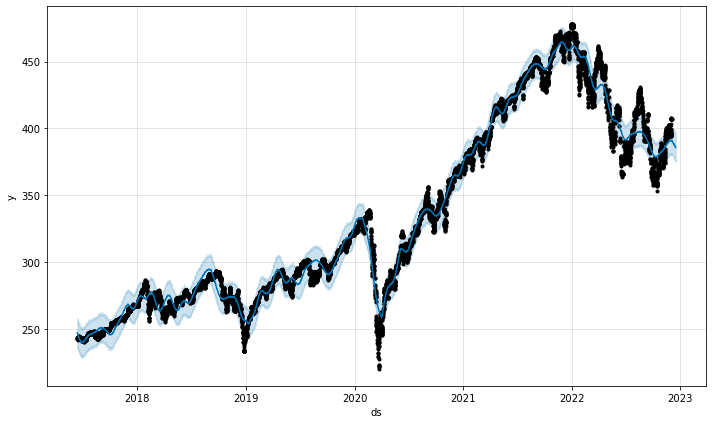

In [88]:
# Python
fig1 = m.plot(forecast)

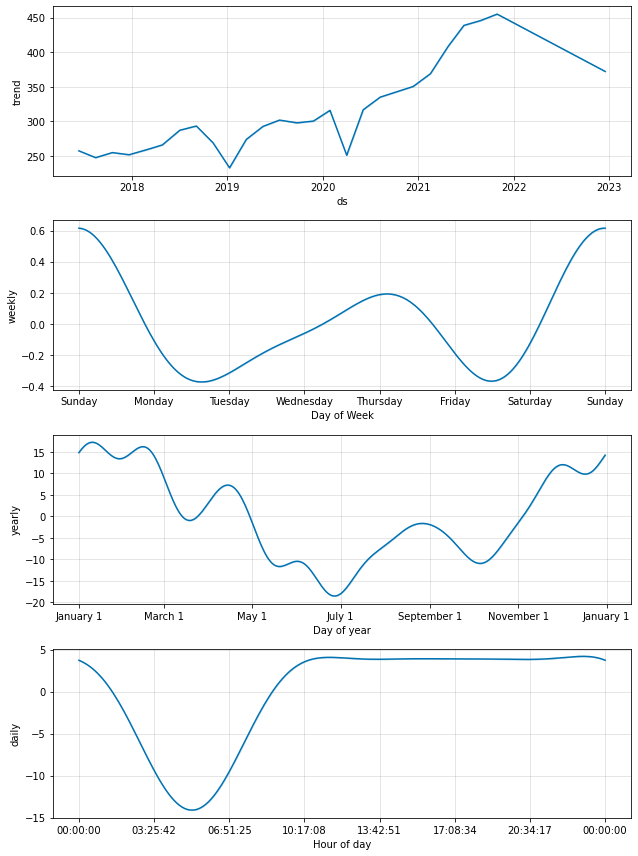

In [89]:
# Python
fig2 = m.plot_components(forecast)

In [90]:
# Python
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

In [91]:
# Python
plot_components_plotly(m, forecast)